# EZmock fitting tutorial

This Jupyter notebook demonstrates the features of the `ezmock` Python package,
from EZmock generation to import and analysis,
for use in quickly calibrating EZmock to a reference catalog.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
import numpy as np
import matplotlib.pyplot as plot

For convenience, you might want to `from ezmock import *`.

In [37]:
import ezmock
from ezmock.fitting_utils import *

In [5]:
HOME_PATH = os.environ['HOME']

Path to the EZmock binary. <span style='color:red'>Replace as appropriate.</span>

In [6]:
# we can't use $HOME because filepaths are shell-escaped by the package
EZMOCK_BINARY = f'{HOME_PATH}/misc/EZmock_eBOSS_LRG_ELG_empty/fortran/pro_EZmock_pk_cf'
PLANCK15PK_PATH = f'{HOME_PATH}/misc/EZmock_eBOSS_LRG_ELG_empty/pks-and-corrs/20191026-planck15-loguniform-pk.dat'

We identify some EZmock parameters we'd like to keep constant for all EZmocks we generate.

In [7]:
ezmock_kwargs = dict(
    verbose=True,
    boxsize=1000,
    grid_num=256,
    redshift=0.9873,
    density=3572102/1e9,
    dilute_factor=0.3,
)

Typically, we calibrate EZmock first by tuning the PDF slope `expect_A_pdf`
and the scatter parameter `scatter2`
until we get matching 2-point statistics in real space,
then tune `zdist_fog` to calibrate in redshift-space.

Finally, we adjust `density_cut` to tune the bispectrum.
Note that adjusting `density_cut` also affects 2-point statistics,
so we must recalibrate those as described above.

In [8]:
a_vals_1 = [0.4, 0.47, 0.55]
s_vals_1 = [1.2, 1.5, 1.8]

In [11]:
ezmock_jobs = [
        ezmock.make_job(
        f'helloworld-s{d2ff(s, 2)}-a{d2ff(a, 2)}',
        ezmock_binary=EZMOCK_BINARY,
        pk_file_path=PLANCK15PK_PATH,
        compute_CF=True,
        compute_CF_zdist=True,
        expect_A_pdf=a,
        scatter2=s,
        density_cut=0,
        zdist_fog=215,
        **ezmock_kwargs,
    )
    for a in a_vals_1
    for s in s_vals_1
]

Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010629-helloworld-s1p20-a0p40.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010633-helloworld-s1p50-a0p40.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010637-helloworld-s1p80-a0p40.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010641-helloworld-s1p20-a0p47.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010645-helloworld-s1p50-a0p47.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010649-helloworld-s1p80-a0p47.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010652-helloworld-s1p20-a0p55.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010656-helloworld-s1p50-a0p55.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010700-h

Side note: `d2ff` is a function that converts a decimal number to a filename-friendly representation:

```
>>> d2ff(3.7, 1)
3p7

>>> d2ff(0.8, 2)
0p80

>>> d2ff(-0.5, 2)
n0p50
```

Now we run the jobs. EZmockJob provides a `chunk` function that takes a list of individual jobs and bundles them into groups of some number of EZmocks for submission to slurm. (In this case, we bundled all 9 together into one big job.)

In [12]:
ezmock.EZmockJob.chunk(ezmock_jobs, 9)[0].run()

Generated sbatch at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010700-499593.sbatch
sbatch /global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010700-499593.sbatch


CompletedProcess(args=['sbatch', '/global/cscratch1/sd/toeknee/ezmock/tempfiles/20201215-010700-499593.sbatch'], returncode=0)

Now that we've generated the EZmocks, we want to load them from disk into Python.

In [9]:
ezmocks1 = {
    (s, a): ezmock.EZmock(f'helloworld-s{d2ff(s, 2)}-a{d2ff(a, 2)}',)
    for s in s_vals_1
    for a in a_vals_1
}

`fitting_utils` provides a number of useful plotting commands to ease the fitting process. For example, we can look at real space 2-point statistics with `compare_ezmocks_with_fiducial`.

Usually, you'd specify the `fiducial` argument to point to an `EnhancedCatalog` object containing information about the reference catalog you're fitting to; consult the `fitting_utils` code for details.

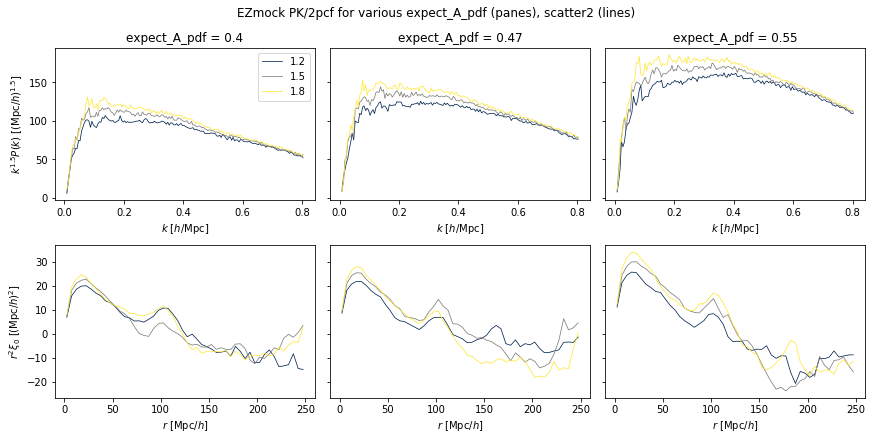

In [19]:
fig, (pk_axs, cf_axs) = compare_ezmocks_with_fiducial(ezmocks1, s_vals_1, a_vals_1, fiducial=None, scatter_major=False)

It's sometimes helpful to group first by `scatter2` rather than the PDF slope; to do so, toggle `scatter_major`.

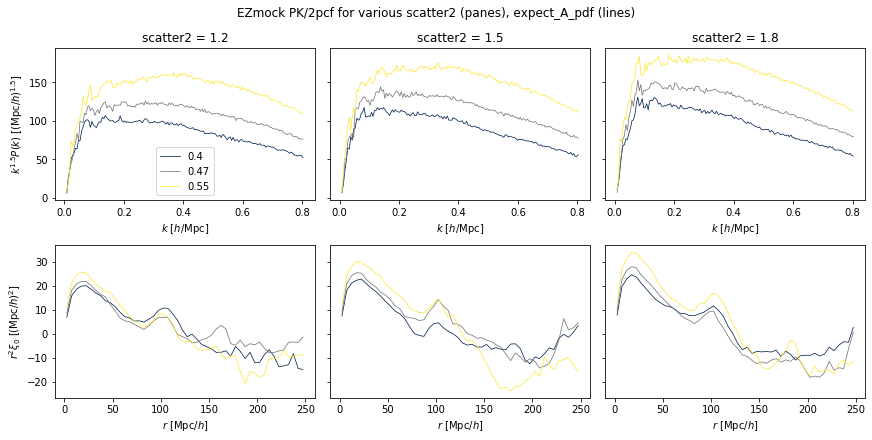

In [20]:
fig, (pk_axs, cf_axs) = compare_ezmocks_with_fiducial(ezmocks1, s_vals_1, a_vals_1, fiducial=None, scatter_major=True)

After iterating and finding a real-space fit that you're happy about,
it's time to fit in redshift space.
There is only one relevant degree of freedom here -- the `zdist_fog` parameter.

In [21]:
fog_vals = [100, 200, 300, 400]

In [23]:
ezmock_jobs_2 = [
        ezmock.make_job(
        f'helloworld-s1p50-a0p47-f{fog}',
        ezmock_binary=EZMOCK_BINARY,
        pk_file_path=PLANCK15PK_PATH,
        compute_CF=True,
        compute_CF_zdist=True,
        expect_A_pdf=0.47,
        scatter2=1.5,
        density_cut=0,
        zdist_fog=fog,
        **ezmock_kwargs,
    )
    for fog in fog_vals
]

Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20210110-140439-helloworld-s1p50-a0p47-f100.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20210110-140443-helloworld-s1p50-a0p47-f200.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20210110-140447-helloworld-s1p50-a0p47-f300.ini
Generated params file at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20210110-140450-helloworld-s1p50-a0p47-f400.ini


In [24]:
ezmock.EZmockJob.chunk(ezmock_jobs_2, 4)[0].run()

Generated sbatch at /global/cscratch1/sd/toeknee/ezmock/tempfiles/20210110-140607-730876.sbatch
sbatch /global/cscratch1/sd/toeknee/ezmock/tempfiles/20210110-140607-730876.sbatch


CompletedProcess(args=['sbatch', '/global/cscratch1/sd/toeknee/ezmock/tempfiles/20210110-140607-730876.sbatch'], returncode=0)

In [30]:
ezmocks2 = {
    fog: ezmock.EZmock(f'helloworld-s1p50-a0p47-f{fog}',)
    for fog in fog_vals
}

(<Figure size 864x432 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaadccf4e10>,
       dtype=object))

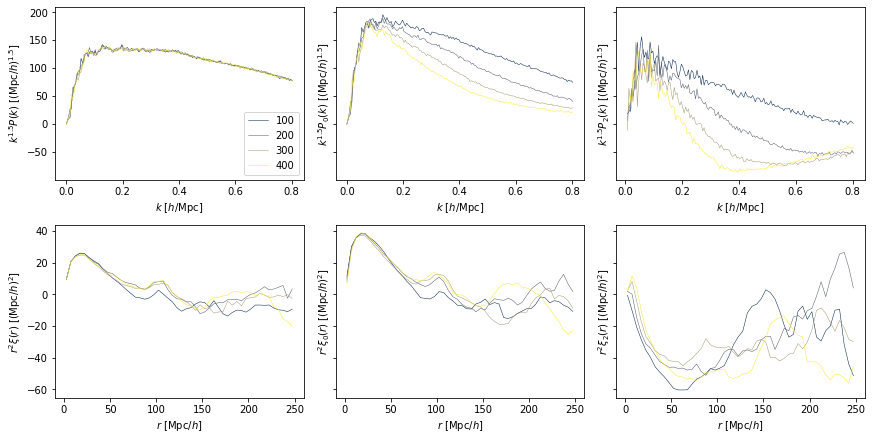

In [34]:
fog_fitting(ezmocks2, fiducial=None)

Let's pretend that $f=300$ gives the best fit in redshift space.
The final step is to fit the bispectrum.
We compute the bispectrum by calling Cheng Zhao's `bispec` command, which you should install.
We'll pretend the $(A, s) = (0.4, 1.2)$ mock from last time is a fiducial.
The following function plots all the bispectra as well as the ratio.

(<Figure size 432x288 with 2 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x2aaadd2bfd90>])

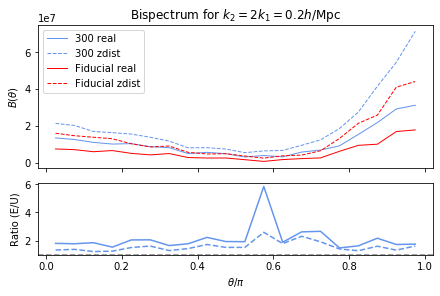

In [45]:
mocks_bispec_comparison(
    [ezmocks2[300]],
    colors=['cornflowerblue'],
    labels=['300'],
    fiducial=ezmocks1[(1.2, 0.4)],
    fid_label='Fiducial',
)

To fit the bispectrum, change the value of the `density_cut` and redo the 2-pt clustering fitting,
then check the BK again.
Iterate until a good fit is found.